# How to solve Multi-Label Classification Problems

# Objective
This tutorial covers the **Multi-Label Classification** Problems in **Deep Learning** with **Tensorflow & Keras**.

#  Import Dependencies

In [ ]:

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import pandas as pd
import pathlib, datetime


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
#!pip install -U tensorboard-plugin-profile

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
!mkdir "logs/"
!ls

In [ ]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

---
---

In [ ]:
#@title Record Each Cell's Execution Time
#!pip install ipython-autotime

%load_ext autotime

This is the **fourth part** of the "***How to solve Classification Problems in Keras?***" series.

Before starting this tutorial,  I strongly suggest you to go over the  **[Part A: Classification with Keras](https://kmkarakaya.medium.com/how-to-solve-classification-problems-in-deep-learning-with-tensorflow-keras-6e39c5b09501)** to learn all related concepts.

The link to all the parts of the series is provided in the video description.

In this tutorial, we will focus on how to solve **Multi-Label Classification** Problems in **Deep Learning** with **Tensorflow & Keras**.

First, we will download a sample Multi-label dataset.

In multi-label classification problems, we mostly **encode** the true **labels**  with multi-hot vectors.

We will experiment with combinations of various last layer's activation functions and loss functions of a Keras CNN model and we will observe the effects of them on the model's performance.

During experiments, we will discuss the relationship between
 ***Activation & Loss functions***,  ***label encodings***, and **accuracy metrics** in details.

We will understand why sometimes we could get **suprising results** when using ***different*** parameter settings other than the generally **recommended** ones.

As a result, we will **gain insight** about activation  and loss functions and their inteactions.

**In the end**, we will summarize the experiment results in a cheat table.

If you would like to learn more about Deep Learning with practical coding examples, please **subscribe** to [my YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists) or **follow** [my blog on Medium](https://medium.com/@kmkarakaya). Do not forget to turn on **Notifications** so that you will be notified when ***new parts are uploaded***.

You can access this **Colab Notebook** using [the link](https://colab.research.google.com/drive/1KsNfjXyR6A_8pN4PCc0fVhLiZoY1XJPY?usp=sharing) given in the video description below.

If you are ready, let's get started!


---
# 1.Download & Process the Dataset  




## Download
First let's load the data from [Image Data for Multi-Instance Multi-Label Learning](https://www.lamda.nju.edu.cn/data_MIMLimage.ashx)

 The image collection contains 2000 natural scene images.

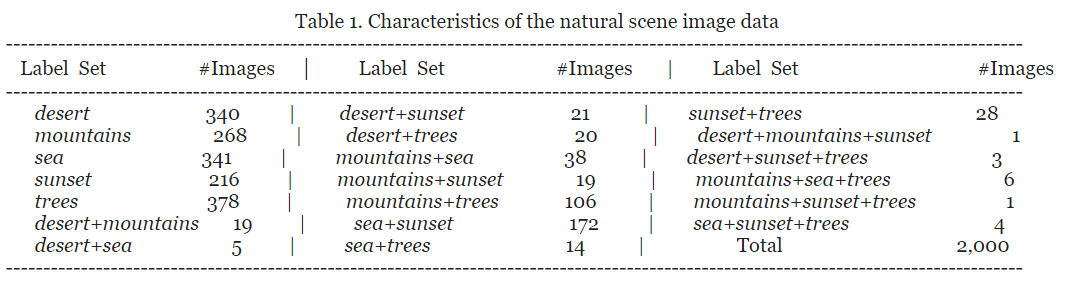

In [ ]:
!wget https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip

## Unzip the data

In [ ]:
!unzip -o -q miml_dataset.zip 

## Check the meta data

In [ ]:
df=pd.read_csv("./miml_dataset/miml_labels_1.csv")
df.head()

## Record the labels

In [ ]:
LABELS=["desert", "mountains", "sea", "sunset", "trees"]

## Prepare Data Pipeline by using tf.data

You can learn how to use tf.data to create your data pipeline [using the link](https://youtu.be/5MQ63pDxULw) given in video descriptions.

### Create a file list using glob 

In [ ]:
data_dir = pathlib.Path("miml_dataset")
filenames = list(data_dir.glob('images/*.jpg'))
fnames=[]
for fname in filenames:
  fnames.append(str(fname))


In [ ]:
ds_size= len(fnames)
print("Number of images in folders: ", ds_size)

number_of_selected_samples=2000
filelist_ds = tf.data.Dataset.from_tensor_slices(fnames[:number_of_selected_samples])

ds_size= filelist_ds.cardinality().numpy()
print("Number of selected samples for dataset: ", ds_size)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  file_name= parts[-1]
  labels= df[df["Filenames"]==file_name][LABELS].to_numpy().squeeze()
  return tf.convert_to_tensor(labels)

### Let's resize and scale the images so that we can save time in training

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 64 , 64
def decode_img(img):
  #color images
  img = tf.image.decode_jpeg(img, channels=3) 
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32) 
  #resize 
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

### Combine the images with labels

In [ ]:
def combine_images_labels(file_path: tf.Tensor):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Decide the train-test split

In [ ]:
train_ratio = 0.80
ds_train=filelist_ds.take(ds_size*train_ratio)
ds_test=filelist_ds.skip(ds_size*train_ratio)

### Decide the batch size

In [ ]:
BATCH_SIZE=64

### Pre-process all the images

In [ ]:
ds_train=ds_train.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)


In [ ]:
ds_test= ds_test.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)


### Convert multi-hot labels to string labels

In [ ]:
def covert_onehot_string_labels(label_string,label_onehot):
  labels=[]
  for i, label in  enumerate(label_string):
     if label_onehot[i]:
       labels.append(label)
  if len(labels)==0:
    labels.append("NONE")
  return labels


## Show some samples from the data pipeline

In [ ]:
def show_samples(dataset):
  fig=plt.figure(figsize=(16, 16))
  columns = 3
  rows = 3
  print(columns*rows,"samples from the dataset")
  i=1
  for a,b in dataset.take(columns*rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a))
    plt.title("image shape:"+ str(a.shape)+" ("+str(b.numpy()) +") "+ 
              str(covert_onehot_string_labels(LABELS,b.numpy())))
    i=i+1
  plt.show()
show_samples(ds_test)

### Notice that above, the True (Actual) Labels are encoded with a **Multi-hot vectors** 

### Prepare the data pipeline by setting batch size & buffer size using [tf.data](https://www.tensorflow.org/guide/data)

In [ ]:
#buffer_size = ds_train_resize_scale.cardinality().numpy()/10
#ds_resize_scale_batched=ds_raw.repeat(3).shuffle(buffer_size=buffer_size).batch(64, )

ds_train_batched=ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched=ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_batched.cardinality().numpy())


# 2. Create a Keras CNN model by using Transfer learning

## Import VGG16

To train fast, let's use Transfer Learning by importing VGG16

In [ ]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(64, 64, 3), # VGG16 expects min 32 x 32
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

## Create the classification model


In [ ]:
number_of_classes = 5

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  tf.keras.activations.sigmoid #None  # tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
model = keras.Model(inputs, outputs)

## Pay attention:
* The last layer has ***number_of_classes*** units. So the output (***y_pred***)  will be **a vector with number_of_classes dimension**.


* For the last layer, the activation function can be:
  * None 
  * sigmoid 
  * softmax
* When there is **no activation** function is used in the model's last layer, we need to set `from_logits=True` **in cross-entropy loss functions** . Thus, **cross-entropy loss functions** will apply a **sigmoid** transformation on **predicted label values** by itself:


# 3. Compile & Train 

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=[keras.metrics.BinaryAccuracy()])

**IMPORTANT:** We need to use **keras.metrics.BinaryAccuracy()** for **measuring** the **accuracy** since it calculates how often predictions matches **binary labels**. 

As we are dealing with **multi-label** classification and true lables are encoded **multi-hot**, we need to compare ***pairwise (binary!)***:  each element of prediction with the corresponding element of true lables. 




## Try & See
Now, we can try and see the performance of the model by using **combination of activation  and loss functions.**

Note: First Epoch (preparing data pipeline) takes 673  seconds on Colab GPU. Next epochs takes only 1 second.

In [ ]:
model.fit(ds_train_batched, validation_data=ds_test_batched, epochs=100)

# 4. Evaulate the model

In [ ]:
ds= ds_test_batched
print("Test Accuracy: ", model.evaluate(ds)[1])

## 10 sample predictions

In [ ]:
ds=ds_test
predictions= model.predict(ds.batch(batch_size=10).take(1))
print("A sample output from the last layer (model) ", predictions[0])
y=[]
print("10 Sample predictions:")
for (pred,(a,b)) in zip(predictions,ds.take(10)):
  
  pred[pred>0.5]=1
  pred[pred<=0.5]=0
  print("predicted: " ,pred, str(covert_onehot_string_labels(LABELS, pred)),  
        "Actual Label: ("+str(covert_onehot_string_labels(LABELS,b.numpy())) +")")
  y.append(b.numpy())

---
# 5. Obtained Results*:





| Activation | Loss | Accuracy |
| :- | -: | :-: |
| softmax | BinaryCrossentropy() |0.8675
| **sigmoid** | **BinaryCrossentropy()** |**0.8810**
| None | BinaryCrossentropy(from_logits=True) | 0.8705
| softmax  |  CategoricalCrossentropy() |0.8665
| sigmoid |  CategoricalCrossentropy() | 0.7460
| None |  CategoricalCrossentropy(from_logits=True) | 0.2540
| softmax | SparseCategoricalCrossentropy() |InvalidArgumentError:  labels must be 1-D, but got shape [64,5]
| sigmoid | SparseCategoricalCrossentropy() | InvalidArgumentError:  labels must be 1-D, but got shape [64,5]
| None | SparseCategoricalCrossentropy(from_logits=True) |InvalidArgumentError:  labels must be 1-D, but got shape [64,5]




   *When you run this notebook, most probably you would not get the exact numbers rather you would observe very similar values due to the stochastic nature of ANNs.* 

# 6. Observations & Discussions

## Why does SparseCategoricalCrossentropy loss functions generate errors?




Because, to **encode** the true labels, we are using **multi-hot vectors**. 

However, SparseCategoricalCrossentropy expects the true labels as an **integer** number.

Moreover, we **can NOT encode** multi-labels as an integer since there would be more than one label for a sample.  

Therefore, the SparseCategoricalCrossentropy loss functions can ***NOT handle multi-hot vector!***

## Why does Sigmoid produce  the best performance when BinaryCrossentropy Loss Function used?

* When **softmax** is applied as the last layer's **activation** function, is is able to ***only select a single label as the prediction*** as softmax normalizes all predicted values as a probability distribution. Only one label could get higer value than 0.5. 

  Thus, **softmax can only predict a SINGLE class at most!** in a multi-label problem! So softmax will ***miss other true labels*** which leads **inferiror** performance compared to **sigmoid**.

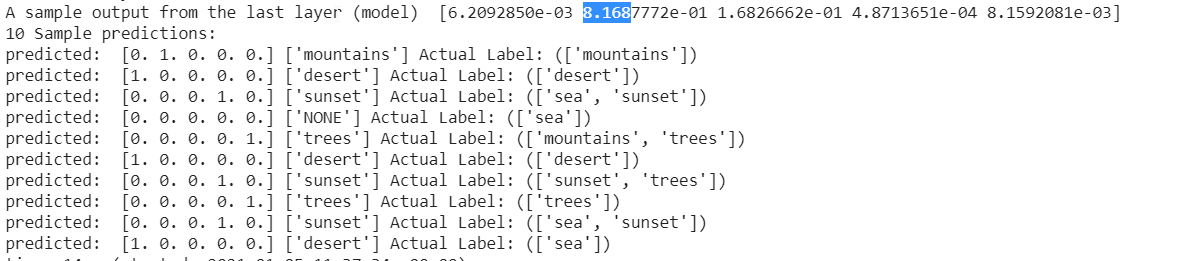

* When **sigmoid** is applied as the last layer's activation function, it is able to ***select multiple labels as the prediction*** as sigmoid normalize each predicted logit values between 0 and 1 independently. 

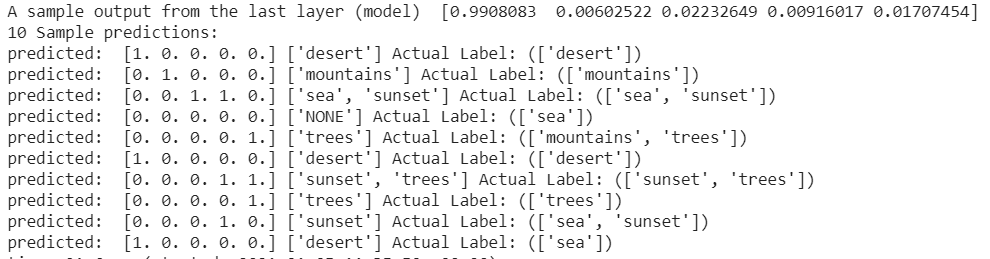

* When no activation function (**None**) is used, each label prediction gets arbitrary numbers from negative infinitive to positive infinitive. BinaryCrossentropy with `from_logits` parameter is set `True` automatically applies sigmoid on these logits. Thus, in this case, we have a similar performance compared to the case where we use sigmoid for the last layer's activation function. 

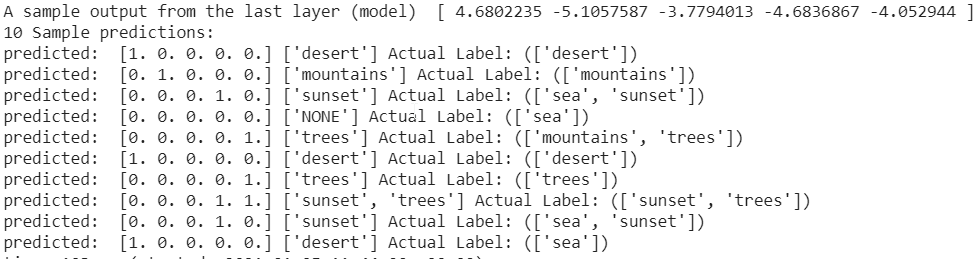

## Does CategoricalCrossentropy loss function generate good results?

***NO!*** At the above table, it looks like that CategoricalCrossentropy with softmax & sigmoid activation functions generates good results. However, if we observe the predictions closely:



* When **softmax** is applied as the last layer's activation function, we can ***only select a single label as the prediction*** as softmax normalize all predicted values as a probability distribution. Only one label could get higer value than 0.5



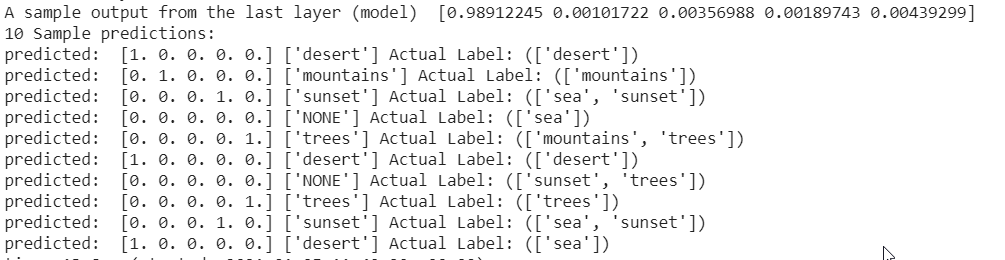

**Important:** Please note that we are using BinaryAccuracy to calculate the accuracy. That is we are comparing true and predicted label vectors by matching one pair ot a time! Thus,the prediction vectors with all 0 or all 1 values can lead considerable good accuracy. 

As we see below, after sigmoid transformation the prediction vector has values equal to almost zeros. However, the binary accuracy is 60% since 3 zeros in true label have been correctly identified!:

In [ ]:
# Assume last layer output is as:
y_pred_logit = tf.constant([[-20, -10.0, -44.5, -12.5, -74]], dtype = tf.float32)
print("y_pred_logit:\n", y_pred_logit.numpy())

# and last layer activation function is sigmoid:
y_pred_sigmoid = tf.keras.activations.sigmoid(y_pred_logit)

y_true=[[1, 0, 0, 0, 1]]
y_pred = y_pred_sigmoid
print("\ny_true {} \n\ny_pred by sigmoid {}\n".format(y_true, y_pred))
print("binary_accuracy: ", tf.keras.metrics.binary_accuracy
      (y_true, y_pred).numpy())

* When **sigmoid** is the activation function & loss is computed by CategoricalCrossentropy function, we ***can NOT select any labels as the prediction*** because all the predicted values get very close to zero.



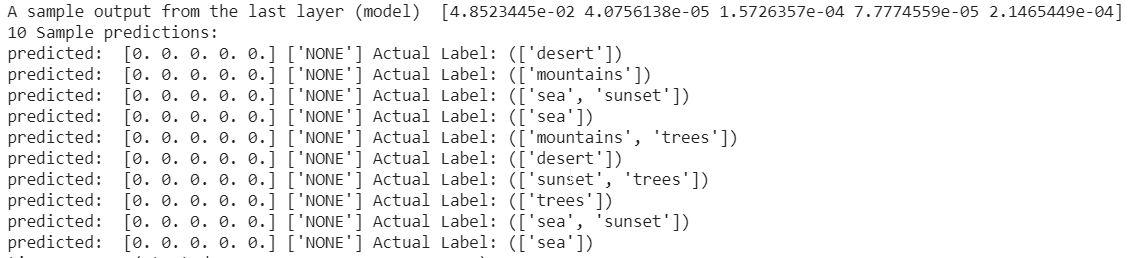

* When **None** of the activation functions is selected & loss is computed by CategoricalCrossentropy function, each label prediction gets arbitrary numbers from negative infinitive to positive infinitive. All predicted label values get higher than 0.5. Thus, **all labels are selected**.

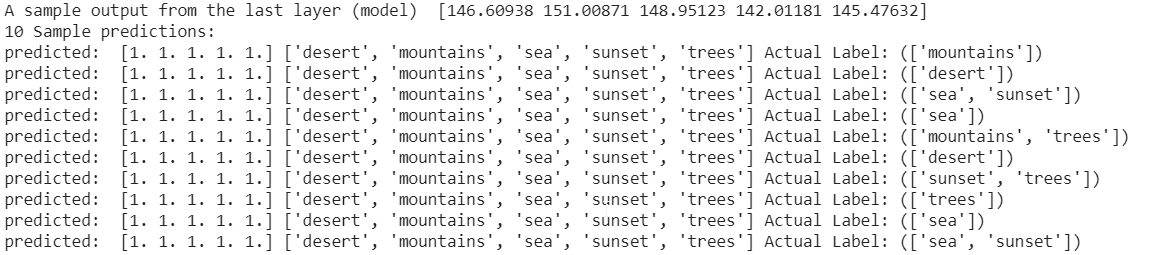

# Multi-Label Classification Summary

According to the above experiment results, if the task is **multi-label classification**, we need to set-up:

* true (actual) labels encoding = **multi-hot vector**

* activation = **sigmoid**

* loss = **BinaryCrossentropy()**

* accuracy metric= **BinaryAccuracy()**







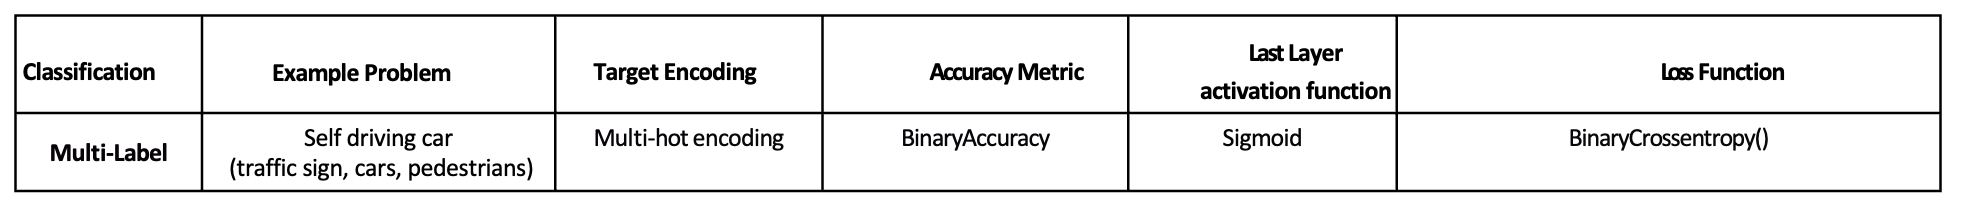

**Acknowledgement:** 
All credits go to [Professor Murat Karakaya](https://www.muratkarakaya.net) and his excellent contributions of this series of deep learning tutorials.


---
# References

- [ Keras API reference / Losses / Probabilistic losses](https://keras.io/api/losses/probabilistic_losses/
) 

- [Keras Activation Functions](https://keras.io/api/layers/activations/)

- [Tensorflow Data pipeline (tf.data) guide](https://www.tensorflow.org/guide/data#using_tfdata_with_tfkeras)

- [How does tensorflow sparsecategoricalcrossentropy work?](https://stackoverflow.com/questions/59787897/how-does-tensorflow-sparsecategoricalcrossentropy-work)


- [Cross-entropy vs sparse-cross-entropy: when to use one over the other](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other)

- [Why binary_crossentropy and categorical_crossentropy give different performances for the same problem?](https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances)